### Imports

In [10]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

import time
import os
import sys
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
torch.set_default_dtype(torch.float32)
sys.path.append("..")

from utils.data_utils import read_data_sets
from optim.FishLeg import FISH_LIKELIHOODS
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Device

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### MNIST Dataset

In [12]:

dataset = read_data_sets("MNIST", "./data/", if_autoencoder=True)

train_dataset = dataset.train
test_dataset = dataset.test

Begin loading data for MNIST
Data read from ./data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./data/data/MNIST_data/train-images-idx3-ubyte.gz


Extracting ./data/data/MNIST_data/t10k-images-idx3-ubyte.gz
Data read from ./data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./data/data/MNIST_data/t10k-labels-idx1-ubyte.gz
Succesfully loaded MNIST dataset.


#### Data Preparation

In [13]:
batch_size = 100

# For training θ 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
# For training λ (auxiliary parameter)
aux_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# for testing
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

### NN

In [14]:
model = nn.Sequential(
    nn.Linear(784, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 30, dtype=torch.float32),
    nn.Linear(30, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 784, dtype=torch.float32),
)

model = model.to(device)

### Loss

In [17]:
likelihood = FISH_LIKELIHOODS["bernoulli"](device=device)

## Adams

#### Optimizer

In [18]:
lr = 0.001
# betas = (0.7, 0.9)
weight_decay = 1e-5
# eps = 1e-8


opt = optim.Adam(
    model.parameters(),
    lr=lr,
    # betas=betas,
    weight_decay=weight_decay,
    # eps=eps,
)

### Training

In [ ]:
epochs = 100

st = time.time()
eval_time = 0

training_loss_Adams = []
testing_loss_Adams = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()

            et = time.time()
            if n % 50 == 0:
                model.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(device), test_batch_labels.to(device)

                    test_output = model(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time
        tepoch.set_postfix(loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time)

        training_loss_Adams.append(running_loss / n)
        testing_loss_Adams.append(running_test_loss)


### Results

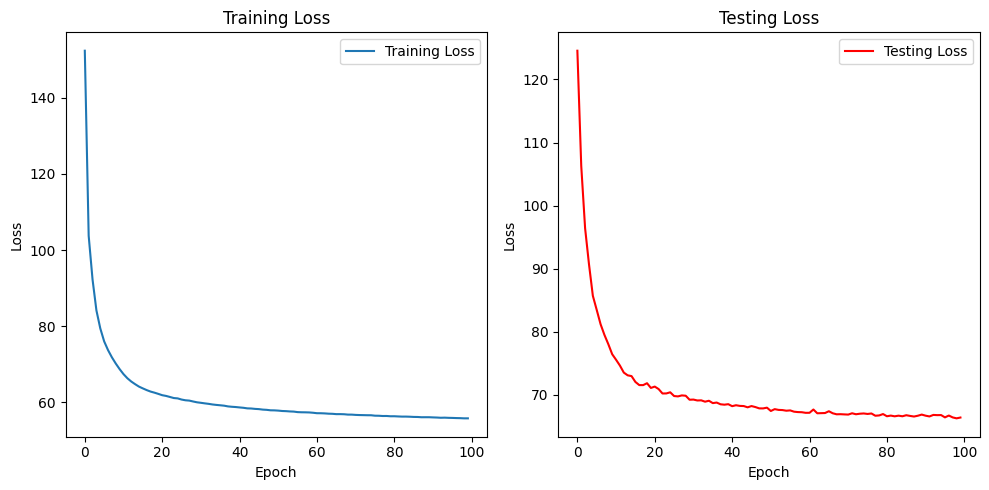

In [20]:
import json
import matplotlib.pyplot as plt

# data_dict = {
#     "training_loss_FishLeg": training_loss_ADAMS,
#     "testing_loss_FishLeg": testing_loss_ADAMS
# }

# with open('loss_data_FishLeg.json', 'w') as f:
#     json.dump(data_dict, f)

# Retrieve data from the JSON file
with open('loss_data_ADAMS.json', 'r') as f:
    loaded_data = json.load(f)

# Plot the data
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(loaded_data['training_loss_ADAMS'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot testing loss
plt.subplot(1, 2, 2)
plt.plot(loaded_data['testing_loss_ADAMS'], label='Testing Loss', color='red')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [7]:
!pwd

/teamspace/studios/this_studio


In [8]:
!ls

Expm.ipynb  data		  main.py    optim	       runs
README.md   loss_data_ADAMS.json  notebooks  requirements.txt  utils
